In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [2]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

In [3]:
torch.manual_seed(1337)

In [4]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()


In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string


In [6]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [7]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [8]:
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


In [9]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out
    

In [10]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [11]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [12]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [13]:
class MyLM_Model(nn.Module):    
  #A Bigram Language Model is a type of statistical language model that 
  #predicts the probability of a word in a sequence based on the preceding word

  def __init__(self):
     super().__init__()

      # each token directly reads off the logits for the next token from a lookup table
     self.token_embedding_table = nn.Embedding(vocab_size,n_embd)
     self.position_embedding_table = nn.Embedding(block_size, n_embd)
     self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
     self.ln_f = nn.LayerNorm(n_embd) # final layer norm
     self.lm_head = nn.Linear(n_embd,vocab_size)
     

  def forward(self,idx,targets=None):
    
    B, T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    tok_emb = self.token_embedding_table(idx) #(Batch,time,channel)
    pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # T,C
    x = tok_emb + pos_emb #(B,T,C)
    x = self.blocks(x) # (B,T,C)
    x = self.ln_f(x) # (B,T,C)
    logits = self.lm_head(x) #(B,T,Vocab_size)
    
    
    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
      for _ in range(max_new_tokens):
          # crop idx to the last block_size tokens
          idx_cond = idx[:, -block_size:]
          # get the predictions
          logits, loss = self(idx_cond)
          # focus only on the last time step
          logits = logits[:, -1, :] # becomes (B, C)
          # apply softmax to get probabilities
          probs = F.softmax(logits, dim=-1) # (B, C)
          # sample from the distribution
          idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
          # append sampled index to the running sequence
          idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
      return idx

In [14]:
model = MyLM_Model()
m = model.to(device)

In [15]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

step 0: train loss 3.9128, val loss 3.9120
step 100: train loss 2.7229, val loss 2.7379
step 200: train loss 2.4230, val loss 2.4883
step 300: train loss 2.2821, val loss 2.4353
step 400: train loss 2.1644, val loss 2.4203
step 500: train loss 2.0546, val loss 2.3728
step 600: train loss 1.9138, val loss 2.3739
step 700: train loss 1.7628, val loss 2.3600
step 800: train loss 1.5910, val loss 2.3932
step 900: train loss 1.4208, val loss 2.4127
step 1000: train loss 1.2344, val loss 2.4315
step 1100: train loss 1.0549, val loss 2.4910
step 1200: train loss 0.8970, val loss 2.5960
step 1300: train loss 0.7415, val loss 2.6260
step 1400: train loss 0.6029, val loss 2.7675
step 1500: train loss 0.5213, val loss 2.8966
step 1600: train loss 0.4465, val loss 3.0765
step 1700: train loss 0.3892, val loss 3.0858
step 1800: train loss 0.3515, val loss 3.1855
step 1900: train loss 0.3161, val loss 3.3026
step 2000: train loss 0.2946, val loss 3.3195
step 2100: train loss 0.2700, val loss 3.4395


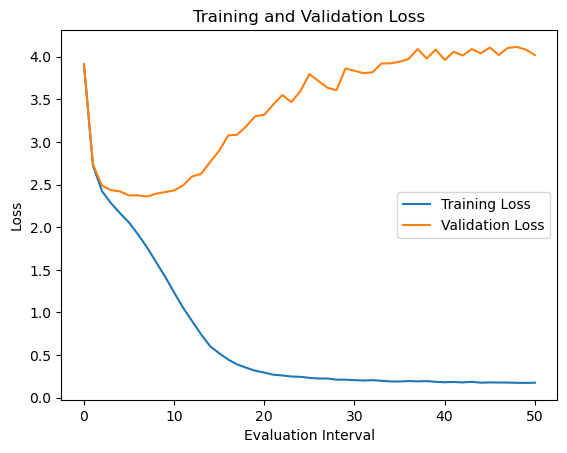

In [16]:
train_losses = []
val_losses = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'].item())
        val_losses.append(losses['val'].item())
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Evaluation Interval')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=1000)[0].tolist()))



OpenAI aims  of concapabing with other institutions, and avoiding uses of AI that may harm humanity or concentrate power.

The organization was founded in December 2015 as a non-profit, with the goal of conducting nhatbots, conduting research to advance AI capabilities and ensured ins pritions ampache sb.

OpenAI and conung-eresfe traitutions, and avoiding uses of AI that may harm humanity or concentratente power.

The organization was founded in December 2015 as a non-profit, with the goal of conducting research to advance AI capabilities and ensure its positive impact. In 2019, OpenAI transitioned to a for-profit company, stating that it would use any influence it obtains over AGI deployment to ensure it is used for the benefit of all.

OpenAI has made significant contributions to the field of AI and natural language processing. They have developed various language models, including the GPT (Generative Pre-trained Transformer) series. GPT models are trained on massive amo enrefach,